In [1]:
import numpy as np
import pickle

In [2]:
def set_ax_borders(ax, top, right, bottom, left):
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)

In [3]:
with open('./Results_exp/ctrgcn_infact_plus_2d_primitive_schedLincos/eval.pkl', 'rb') as f:
    ctrgcn_2d = pickle.load(f)

In [4]:
gt_labels = np.array([i['gt_label'].item() for i in ctrgcn_2d])
pred_labels = np.array([i['pred_label'].item() for i in ctrgcn_2d])
pred_feats = np.array([i['pred_feats'].numpy() for i in ctrgcn_2d])

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
POSTURE_LABEL2IDS = {'Supine': 0, 'Prone': 1, 'Sitting': 2, 'Standing': 3, 'All-fours': 4}
POSTURE_IDS2LABEL = {v:k for k,v in POSTURE_LABEL2IDS.items()}

def get_acc(gts, preds):
    assert len(preds)==len(gts), 'Predictions and Ground truths lenghts are incompatible'
    return (preds==gts).sum()/len(gts)

def plot_cm(gts, preds, ax=None):
    acc = get_acc(gt_labels, pred_labels)
    labels = list(POSTURE_IDS2LABEL.values())
    cm = ConfusionMatrixDisplay.from_predictions(y_true=gts, y_pred=preds, normalize='true', display_labels=labels, ax=ax, values_format='.2f', cmap='Blues')
    cm.ax_.set_title(f"Accuracy: {acc*100:.2f}%")
    return cm

def compress_latents(latents, compressor_method=PCA, ax=None):
    compressor = compressor_method(n_components=2)
    pred_feats = compressor.fit_transform(latents)
    return pred_feats

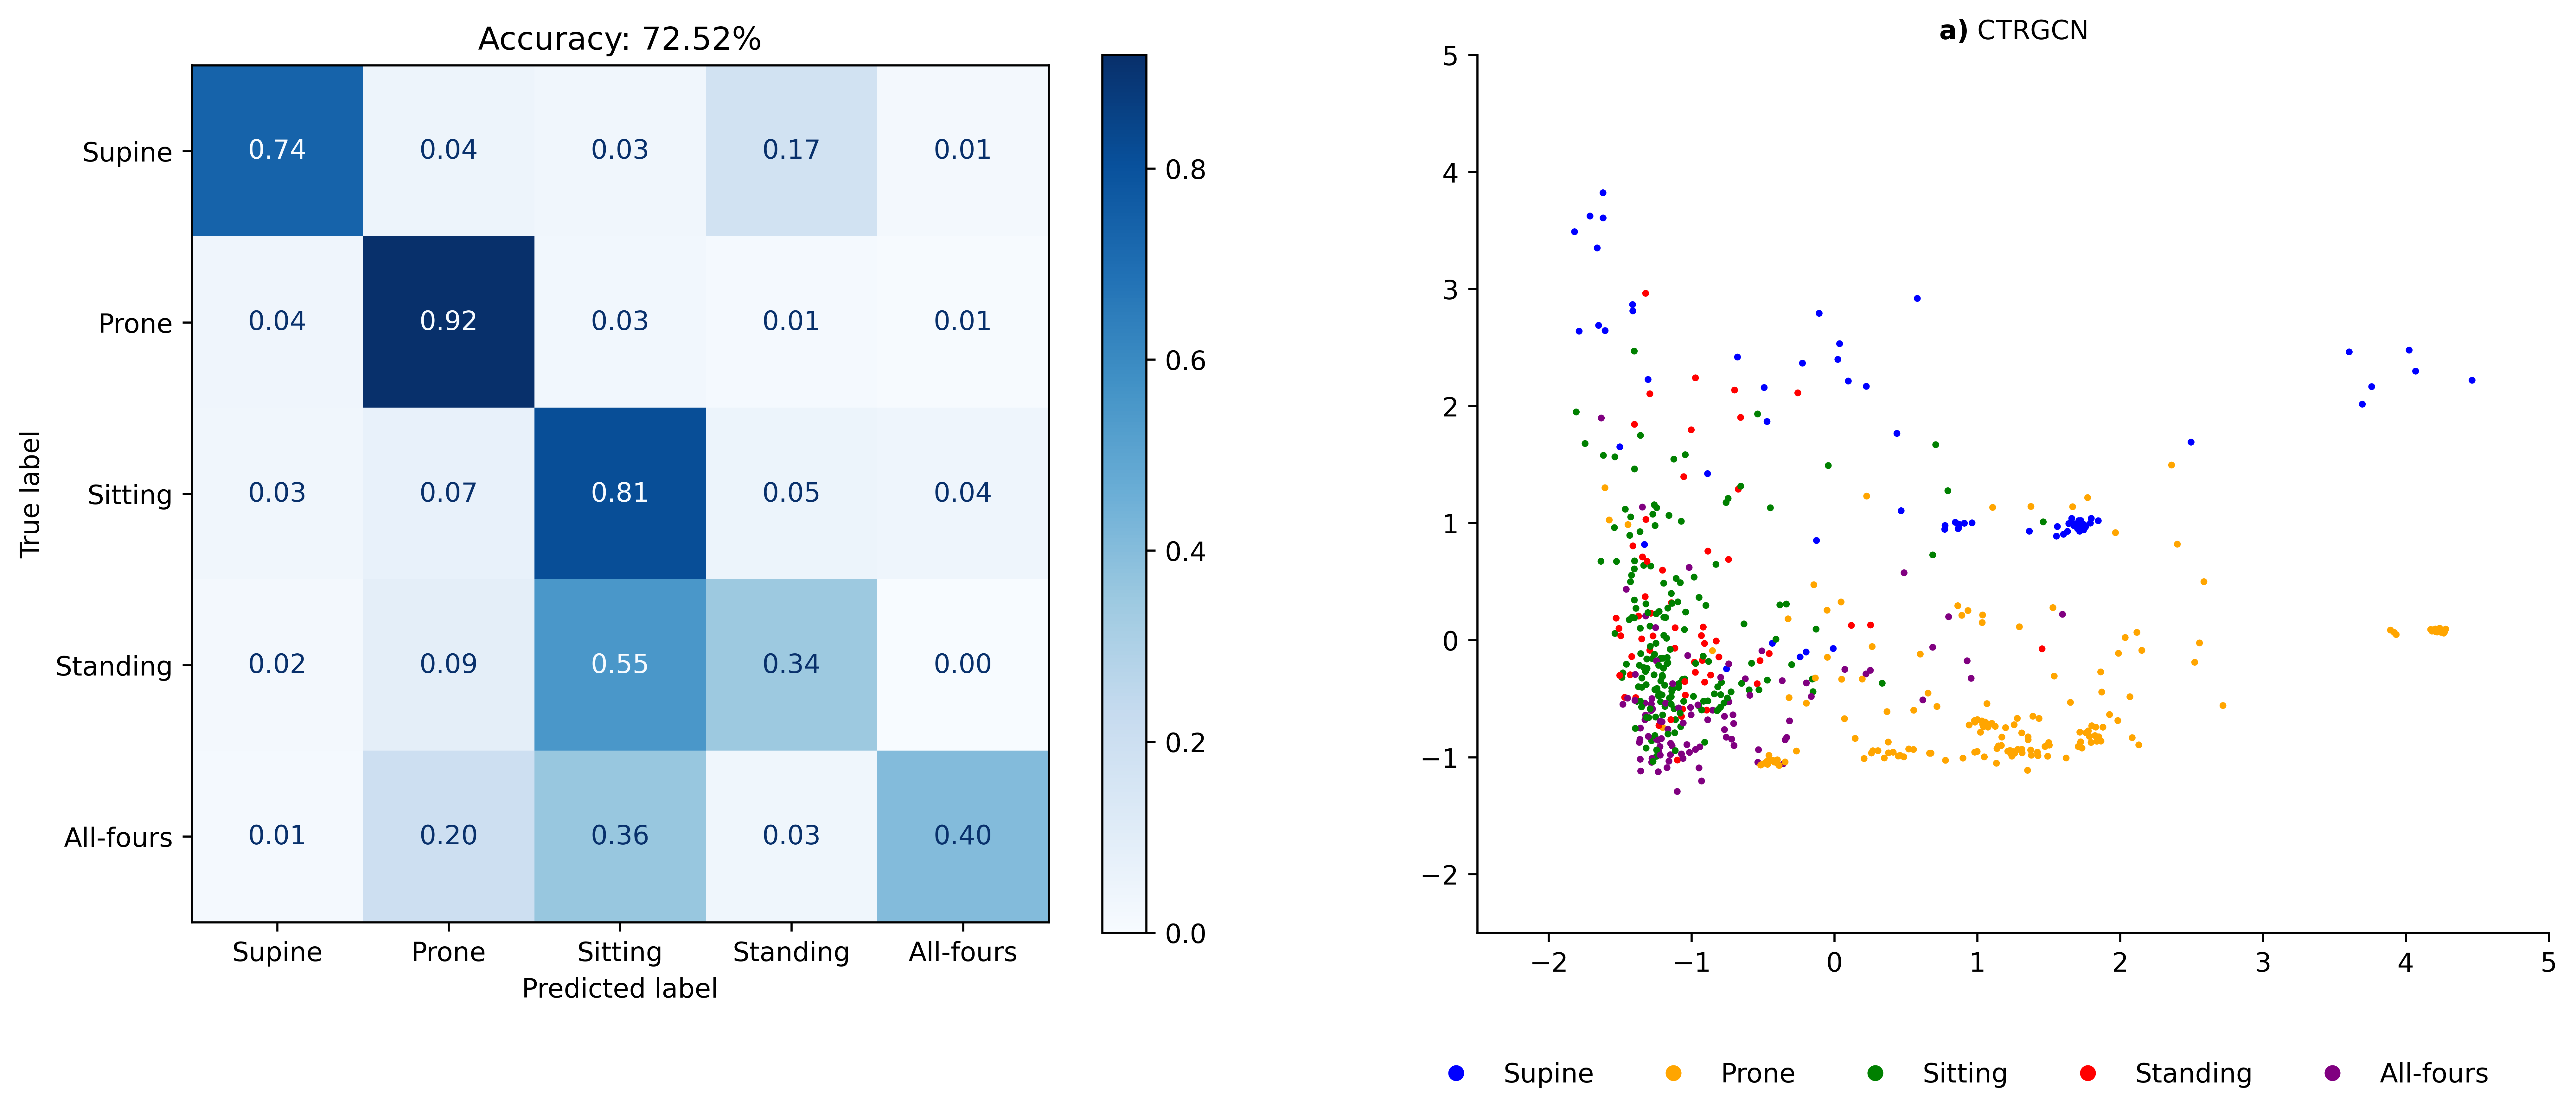

In [6]:
import matplotlib
import matplotlib
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import matplotlib.lines as mlines

COLORS = ['blue', 'orange', 'green', 'red', 'purple']
CLASS_LABELS = ['Supine', 'Prone', 'Sitting', 'Standing',  'All-fours']

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(16,6)
fig.set_dpi(600)

latents = compress_latents(pred_feats, compressor_method=PCA)

plot_cm(gt_labels, pred_labels, ax=axes[0])
axes[1].set_title(r"$\bf{a)}$ CTRGCN", fontsize=10)
axes[1].scatter(latents[:,0], latents[:,1], c = gt_labels, cmap=matplotlib.colors.ListedColormap(COLORS), s=10, marker='.')
axes[1].set_xlim(-2.5, 5)
axes[1].set_ylim(-2.5, 5)
set_ax_borders(axes[1], False, False, True, True)

handles = []
for i, label in enumerate(CLASS_LABELS):
    l = mlines.Line2D([], [], color=COLORS[i], marker='.', linestyle='None',
                            markersize=10, label=f"{label}")
    handles.append(l)

plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.12),
          fancybox=False, shadow=False, ncol=6, handles=handles, frameon=False)
plt.savefig('./ctrgcn_cm+latents.png')


In [7]:
with open('./Results_exp/ctrgcn_infact_plus_2d_primitive_schedLinCos/20240201_145338/20240201_145338.log') as f:
    res = f.readlines()

In [8]:
train_lines = [l for l in res if 'Epoch(train)' in l][1::2]
val_lines = [l for l in res if 'Epoch(val)' in l]

train_losses = np.array([float(l.split()[20]) for l in train_lines])
train_lr = np.array([float(l.split()[10]) for l in train_lines])
train_accs = np.array([float(l.split()[22]) for l in train_lines])
val_accs = np.array([float(l.split()[10]) for l in val_lines])

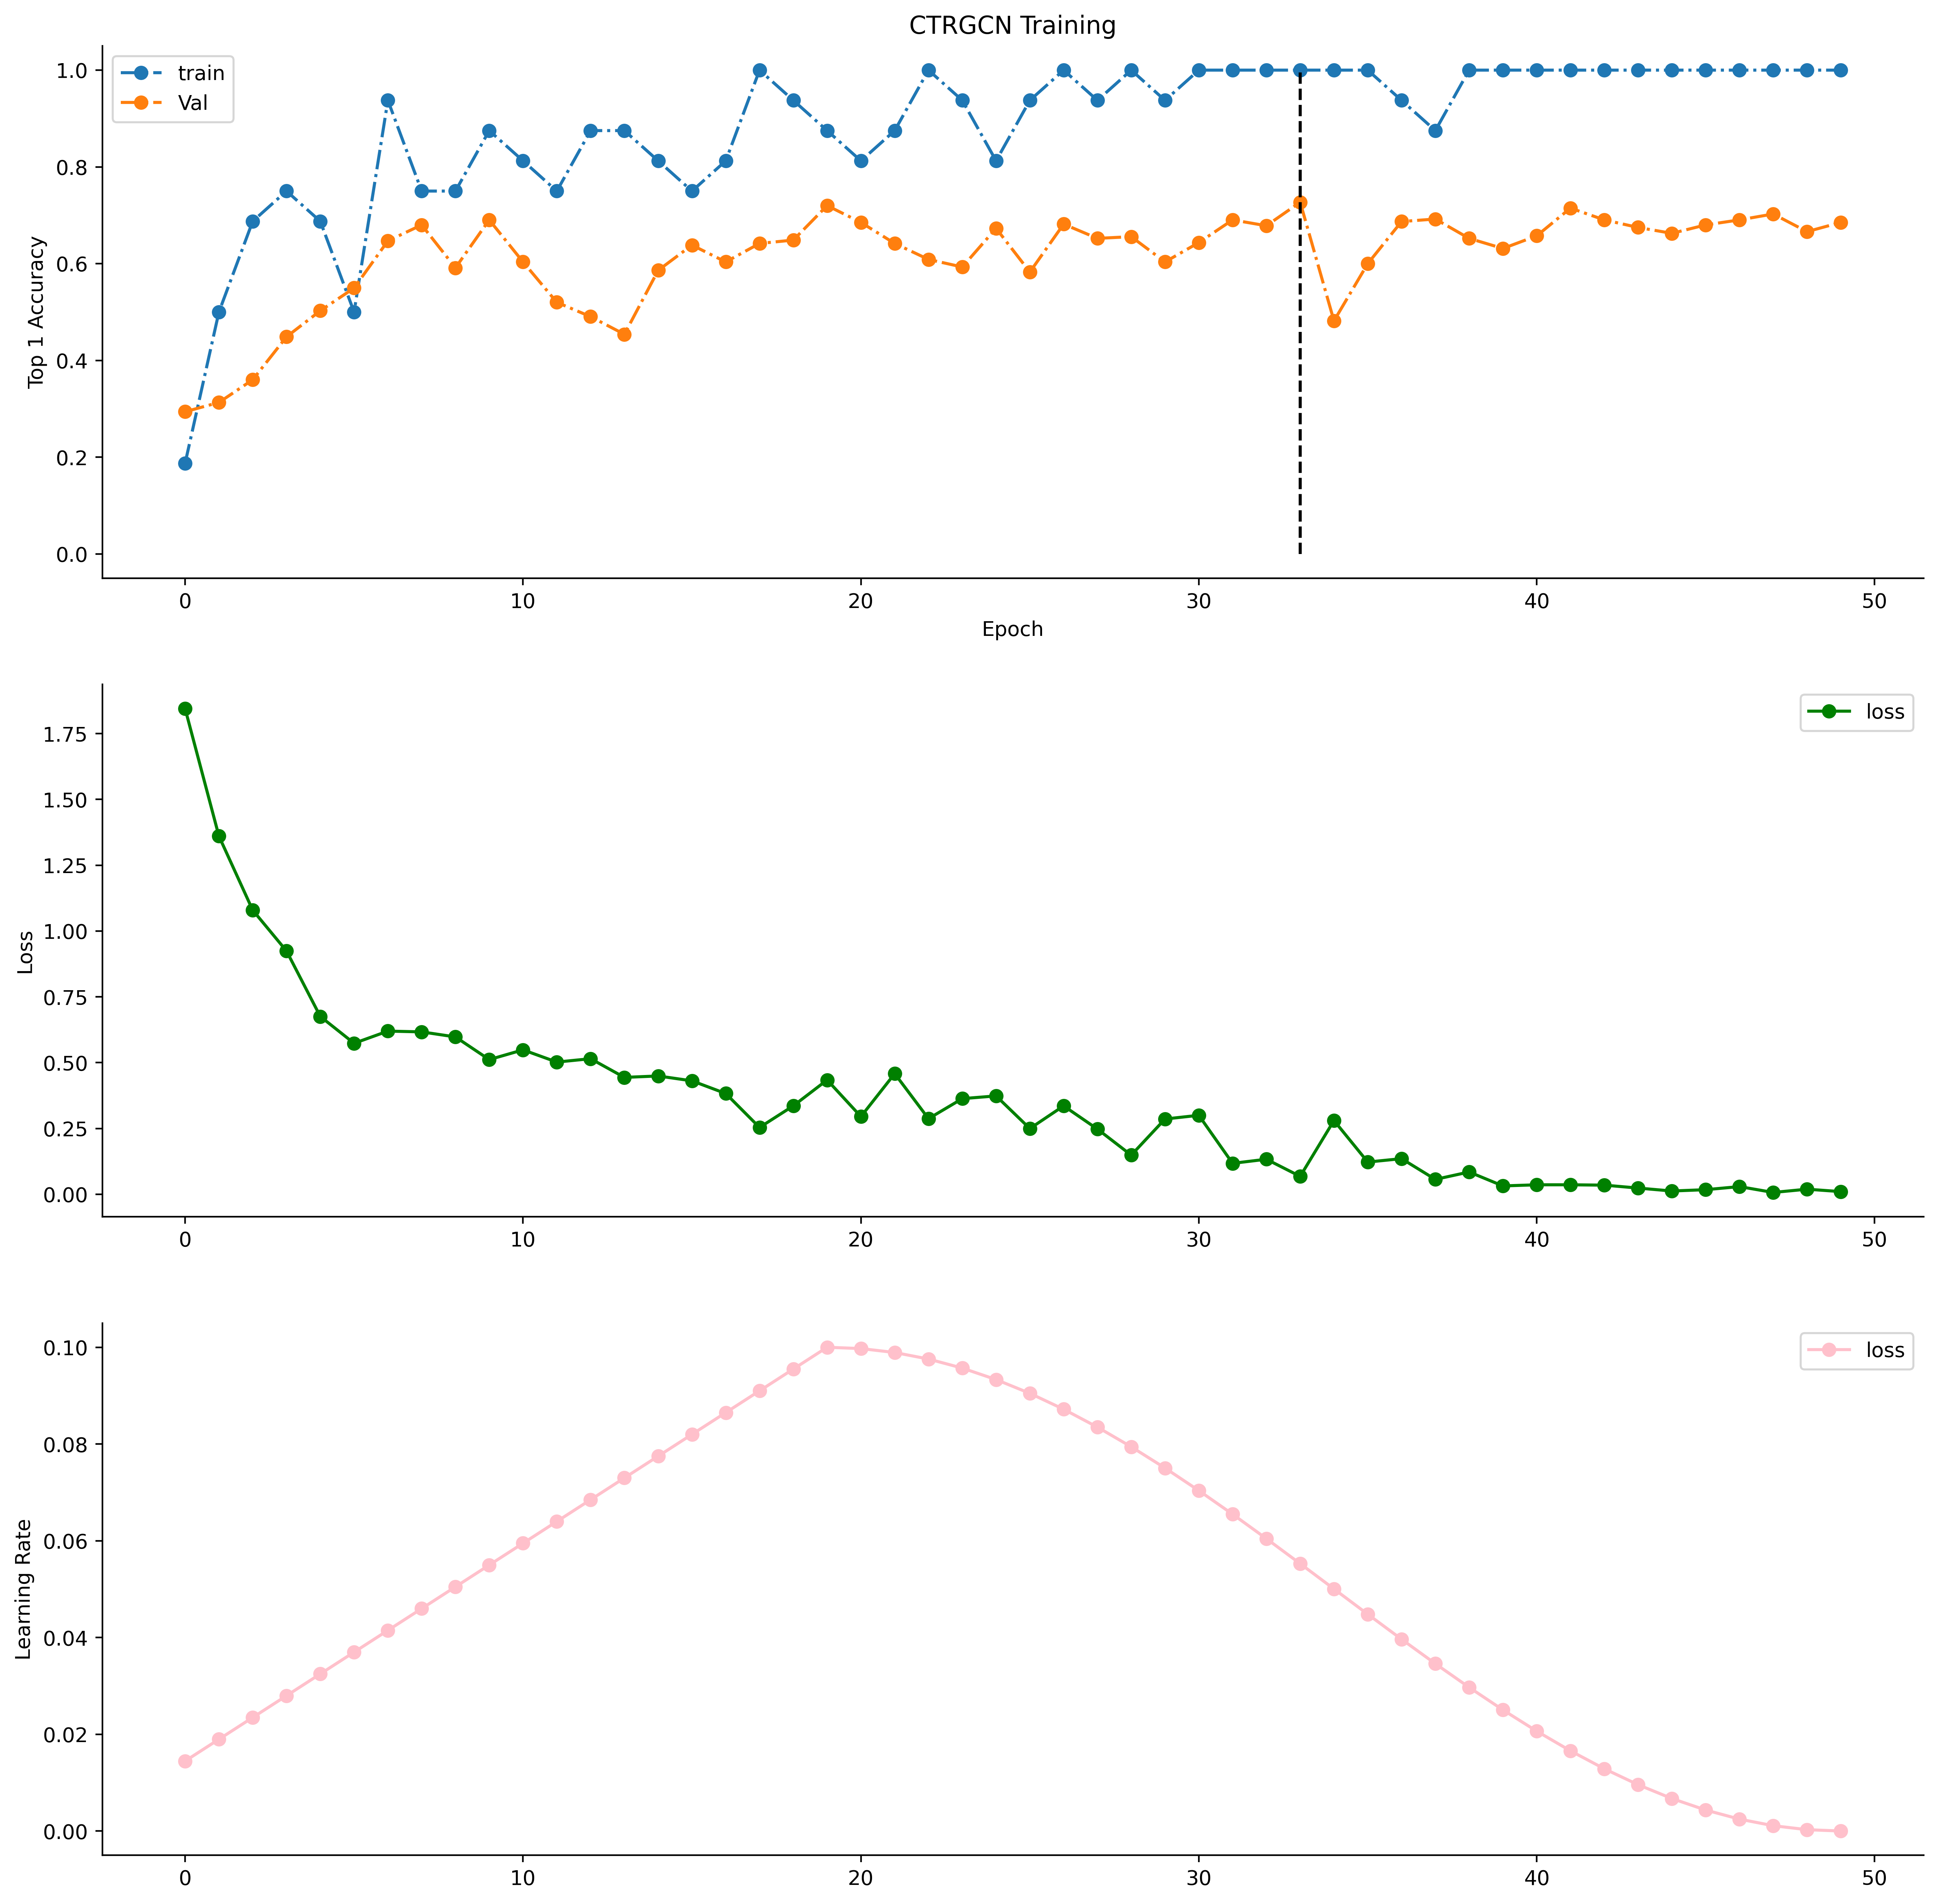

In [9]:
fig, axes = plt.subplots(nrows=3)
fig.set_size_inches(16,16)
fig.set_dpi(400)

axes[0].plot(train_accs, ls='-.', marker='o', label='train')
axes[0].plot(val_accs, ls='-.', marker='o', label='Val')
axes[0].vlines(x=np.argmax(val_accs), ymin=0, ymax=1, color='black', ls='--')
axes[0].set_ylabel('Top 1 Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_title('CTRGCN Training')
axes[0].legend(loc=0)
set_ax_borders(axes[0], False, False, True, True)

axes[1].plot(train_losses, ls='-', marker='o', label='loss', color='green')
axes[1].legend(loc=0)
axes[1].set_ylabel('Loss')
set_ax_borders(axes[1], False, False, True, True)

axes[2].plot(train_lr, ls='-', marker='o', label='loss', color='pink')
axes[2].legend(loc=0)
axes[2].set_ylabel('Learning Rate')
set_ax_borders(axes[2], False, False, True, True)

plt.savefig('./ctrgcn_training.png')


In [10]:
with open('./Data/InfAct_plus/2d/primitive/InfAct_plus.pkl', 'rb') as f:
    infact_ds = pickle.load(f)

val_files = [item for item in infact_ds['annotations'] if item['frame_dir'] in infact_ds['split']['val']]
val_length = np.array([item['total_frames'] for item in val_files])

predict_correct_lengths = val_length[gt_labels==pred_labels]
predict_incorrect_lengths = val_length[gt_labels!=pred_labels]

C:\Users\pouri\AppData\Local\Temp\ipykernel_28160\3829109566.py:6: RuntimeWarning: invalid value encountered in true_divide
  corrected_ratio = corrected_vals/all_vals


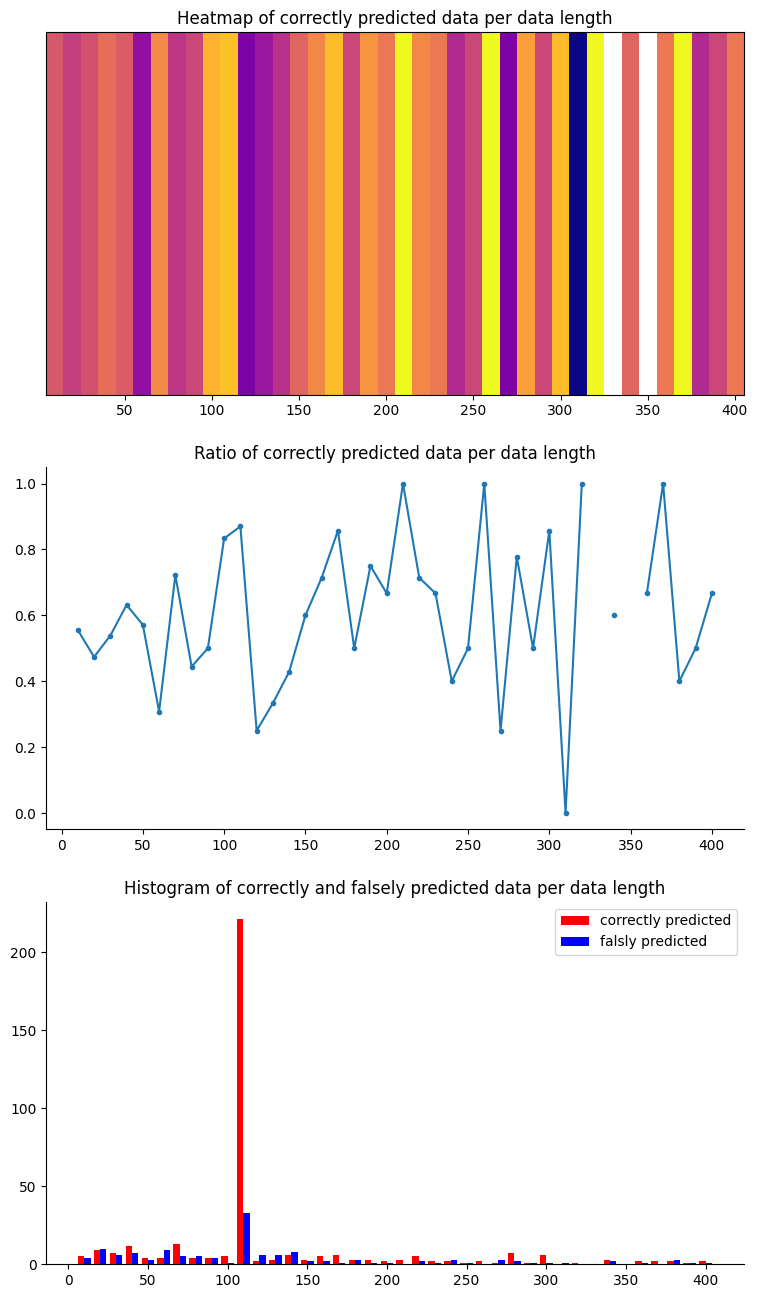

In [11]:
bins = [*np.arange(0,401,10),]
all_vals, all_bins = np.histogram(val_length, bins)
corrected_vals, corrected_bins = np.histogram(predict_correct_lengths, bins)
incorrected_vals, incorrected_bins = np.histogram(predict_incorrect_lengths, bins)
assert np.all(corrected_vals+incorrected_vals==all_vals)
corrected_ratio = corrected_vals/all_vals
corrected_ratio

fig, (ax_t, ax_m, ax_b) = plt.subplots(nrows=3)
fig.set_size_inches(9,16)
extent = [all_bins[1]-(all_bins[1]-all_bins[0])/2., all_bins[-1]+(all_bins[1]-all_bins[0])/2.,0,1]
ax_t.imshow(corrected_ratio[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent, )
ax_t.set_yticks([])
ax_t.set_title('Heatmap of correctly predicted data per data length')

ax_m.plot(all_bins[1:], corrected_ratio, marker='.')
ax_m.set_title('Ratio of correctly predicted data per data length')
set_ax_borders(ax_m, False, False, True, True)

width=-4
ax_b.bar(all_bins[1:], corrected_vals, color='red', width=width, align='edge', label='correctly predicted')
ax_b.bar(all_bins[1:], incorrected_vals, color='blue', width=-width, align='edge', label='falsly predicted')
ax_b.legend()
ax_b.set_title('Histogram of correctly and falsely predicted data per data length')
set_ax_borders(ax_b, False, False, True, True)
plt.savefig('./ctrgcn_prediction_per_length.png')
plt.show()